# Video 2 - ConvNets, parameter regression and SWYFT

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
import pylab as plt
import numpy as np
from torch import nn

## Generator for images with an H

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [43]:
H = np.array([
    [1, -1, 1],
    [1, 1, 1],
    [1, -1, 1]
])

def model(v):
    k = np.random.randint(50000)
    bkg = trainset[k][0].sum(axis=0).numpy()
    i, j = int(v[0]*30), int(v[1]*30)
    img = bkg*1.
    img[i:i+3, j:j+3] += H
    return dict(x = img)

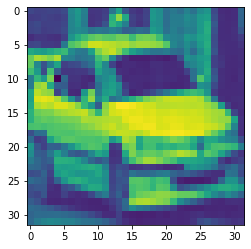

In [56]:
v = np.random.rand(2)
img = model(v)
plt.imshow(img['x'])

Goal: Derive posterior for the position of the "H" in the image.

## SWYFT!

Simplest case without "head" network, where the feature vector $f$ is directly equated with the simulation data:
$$
r(x, z) = \text{MLP}_\phi (f = x, z)
$$

If we have a head network
$$
r(x, z) = \text{MLP}_\phi (f = \text{Head}_\phi(x), z)
$$

The job of a head network is to map the data onto informative feature vectors that are subsequently used in the MLP for parameter inference.

In our case, $f$ should be at least 2-dim since it has to encode a 2-dim position.

In [58]:
import swyft

In [59]:
sim = swyft.Simulator(model, 2, dict(x = (32, 32)))
store = swyft.MemoryStore(sim)

prior = swyft.Prior(lambda u: u, 2)   # Uniform(0, 1)
store.add(10000, prior)
store.simulate()

dataset = swyft.Dataset(10000, prior, store)

Creating new store.
Store: Adding 9942 new samples to simulator store.


In [61]:
# Head network: Embedding of simulation data into (typically 2- to 100-dim) feature-vector space

# Example 1: A regular convolutional neural network, which here maps 32x32 input images on a 2-dim feature vector
# Number of parameters: >1e5 

class ConvHead1(swyft.Module):  # REQUIRED: Parent class has to be swyft.Module
    def __init__(self, obs_shapes):
        super().__init__(self, obs_shapes)  # REQUIRED: Enables easy storage / reloading of training results via swyft (more later)
        self.n_features = 2  # REQUIRED: Number of output features
        
        self.c1 = torch.nn.Conv2d(1, 4, 3)  # Conv2d: 1 -> 4 channels, 3x3 kernel
        self.c2 = torch.nn.Conv2d(4, 16, 3)  # Conv2d: 4 -> 16 channels, 3x3 kernel
        self.c3 = torch.nn.Conv2d(16, 32, 3)  # ...
        self.l1 = torch.nn.Linear(128, 1024)
        self.l2 = torch.nn.Linear(1024, 2)
        self.m = torch.nn.MaxPool2d(2)
        
    def forward(self, sims):
        x = sims['x']
        nbatch = len(x)
        x = x.unsqueeze(1)
        x = torch.relu(self.m(self.c1(x)))
        x = torch.relu(self.m(self.c2(x)))
        x = torch.relu(self.m(self.c3(x)))
        x = x.reshape(nbatch, -1)
        x = self.l2(torch.relu(self.l1(x)))
        return x

In [62]:
post = swyft.Posteriors(dataset)

In [63]:
m = [(0, 1)]
post.add(m, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), head = ConvHead1)

In [64]:
%%time
post.train(m)

Training: lr=0.001, Epoch=24, VL=0.3803
CPU times: user 34.8 s, sys: 7.24 s, total: 42.1 s
Wall time: 48.1 s


In [65]:
test_store = swyft.MemoryStore(sim)
test_store.add(100, prior)
test_store.simulate()
test_dataset = swyft.Dataset(100, prior, test_store)

Creating new store.
Store: Adding 108 new samples to simulator store.


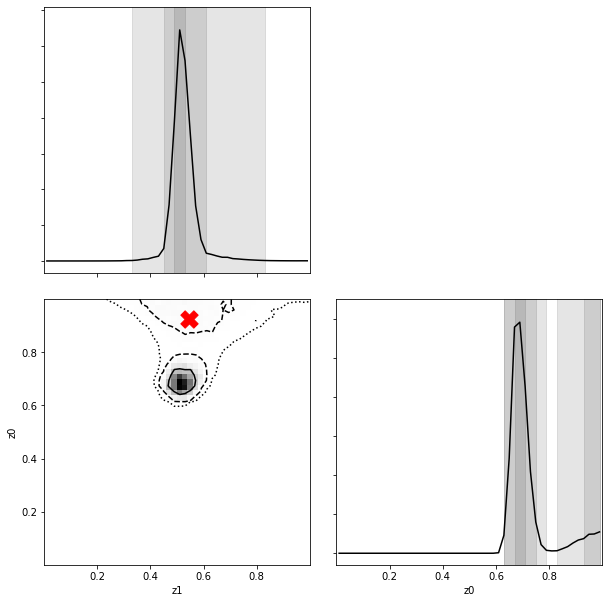

In [104]:
I = np.random.randint(100)
obs = test_dataset[I][0]
z = test_dataset[I][2]
samples = post.sample(100000, obs)
fig, _ = swyft.plot_corner(samples, [1, 0], bins = 50)
fig.axes[2].scatter(z[1], z[0], s= 300, marker='X', color='red', zorder = 10)

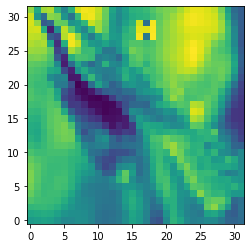

In [105]:
plt.imshow(test_dataset[I][0]['x'], origin='lower')